# Titanic Survival Prediction

This project is Part 2 of my 'Titanic survival prediction' project. 

The result from part 1, I found that the best model is **Random Forest and eXtream Gradient Boosting Model** with public score 0.8062.

The goal of part 2, I will try to Build a **Tensor Flow Keras Sequential Model** and see what the result is.


The contents of this part, I will have a quick data cleaning and feature engineering. 

I will skip the part of data visualisation. 

If you want to see more details of all data preprocessing, you can go to my Titanic part 1 as link below:

https://www.kaggle.com/code/kamalapousajja/titanic-survival-prediction-top4-score-0-8062

Now Let's start to create Neural Network with Keras. 

79.01 schlecht


In [1]:
# Import Libraries
import numpy as np 
import pandas as pd 
import seaborn as sns

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import metrics 
from sklearn.metrics import confusion_matrix,classification_report 
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold,StratifiedShuffleSplit,StratifiedKFold

# Import the necessary Keras functions
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D,MaxPool2D

# Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read the data

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#sample_submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [3]:
# Merge train and test datasets 

all_data = pd.concat([train,test])

all_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Cleaning

In [4]:
# Create 'Title' column from 'Name' column

all_data['Title'] = all_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# Group the Title value
all_data['Title'] = all_data['Title'].replace(['Miss','Ms', 'Mlle'], 'Miss')
all_data['Title'] = all_data['Title'].replace(['Mrs', 'Mme'], 'Mrs')
all_data['Title'] = all_data['Title'].replace(['Capt','Col', 'Major','Dr', 'Rev'], 'Officer')
all_data['Title'] = all_data['Title'].replace(['Sir','Lady','the Countess','Jonkheer','Dona','Don'], 'Royalty')

# Check the Title column
pd.crosstab(all_data['Title'],all_data['Survived']).T

Title,Master,Miss,Mr,Mrs,Officer,Royalty
Survived,,,,,,
0.0,17,55,436,26,13,2
1.0,23,130,81,100,5,3


In [5]:
#Filling the missing values of Age with mean values group by Title.

all_data["Age"].fillna(all_data.groupby(['Title'])['Age'].transform("mean"), inplace=True)

In [6]:
# Fill missing fare with median

all_data['Fare'].fillna(all_data['Fare'].median(), inplace = True)

In [7]:
# Change the label of Sex column

label = LabelEncoder()

all_data['Sex'] = label.fit_transform(all_data['Sex'])

In [8]:
# Create 'Family size' column by combine 'Parent/Childern' and 'Siblings/Spouses' and plus 1 is yourself

all_data['FamilySize'] = all_data['Parch'] + all_data['SibSp'] + 1

pd.crosstab(all_data['FamilySize'],all_data['Survived']).T

FamilySize,1,2,3,4,5,6,7,8,11
Survived,,,,,,,,,
0.0,374,72,43,8,12,19,8,6,7
1.0,163,89,59,21,3,3,4,0,0


In [9]:
# Create 'LastName' column from 'Name' column

all_data['LastName'] = all_data['Name'].str.split(',').str[0]

In [10]:
# Create the 'ConnectedSurvival' column

all_data['ConnectedSurvival'] = 0.5

for _, data_same in all_data.groupby('Ticket'):
    if (len(data_same) > 1):
        for ind, row in data_same.iterrows():
            smax = data_same.drop(ind)['Survived'].max()
            smin = data_same.drop(ind)['Survived'].min()
            passid = row['PassengerId']
            
            if (smax == 1):
                all_data.loc[all_data['PassengerId'] == passid, 'ConnectedSurvival'] = 1
            elif (smin == 0):
                all_data.loc[all_data['PassengerId'] == passid, 'ConnectedSurvival'] = 0

all_data.groupby('ConnectedSurvival')['Survived'].mean()

ConnectedSurvival
0.0    0.225352
0.5    0.297989
1.0    0.727723
Name: Survived, dtype: float64

In [11]:
# Check the column name

all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'FamilySize',
       'LastName', 'ConnectedSurvival'],
      dtype='object')

In [12]:
# Delete unnecessary column

data_final = all_data.drop(['PassengerId','Name','Title','SibSp','Parch', 'Ticket','Cabin', 'Embarked','LastName'], axis=1)

data_final.head()

,Survived,Pclass,Sex,Age,Fare,FamilySize,ConnectedSurvival
0,0.0,3,1,22.0,7.2500,2,0.5
1,1.0,1,0,38.0,71.2833,2,0.5
2,1.0,3,0,26.0,7.9250,1,0.5
3,1.0,1,0,35.0,53.1000,2,0.0
4,0.0,3,1,35.0,8.0500,1,0.5


In [13]:
# Reform splits to train, test dataset

df_train = data_final[:len(train)]
df_test = data_final[len(train):]

df_test.drop('Survived', axis=1, inplace=True)

In [14]:
# Set X and y variables of the features

X = df_train.drop('Survived', axis=1)

y = df_train['Survived']

In [15]:
# Perform a train/test split 

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=0)

In [16]:
# Normalizing the Data
# Use a MinMaxScaler to normalize the feature data X_train and X_valid. 
# Recall we don't want data leakge from the test set so we only fit on the X_train data.
    
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
df_test = scaler.transform(df_test)

# Create a Model

**Build a tf.keras.Sequential model:**

Sequential is useful for stacking layers where each layer has one input tensor and one output tensor. 

Layers are functions with a known mathematical structure that can be reused and have trainable variables. 

Most TensorFlow models are composed of layers. 

This model uses the Flatten, Dense, and Dropout layers.

In [17]:
X_train.shape

(712, 6)

In [18]:
# Build a sequential model to will be trained on the data.

model = Sequential()

# Flattens the data into a 1d array
model.add(Flatten())

# Input the first layer 
model.add(Dense(6, activation='relu'))

#Drops 0.2 of the values from the next layer, so it does not over fit.
model.add(Dropout(0.2))

# Hidden layer
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.2))

# Hidden layer
model.add(Dense(80, activation='relu'))
model.add(Dropout(0.2))

# Hidden layer
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.2))

# Hidden layer
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))


# Output layer that is binary [0,1]
model.add(Dense(units=1,activation='sigmoid'))

**Compile model**

Before start training, configure and compile the model using Keras Model.compile. 

Set the loss to the 'binary_crossentropy' function, 

Set the optimizer class to adam, 

and specify a metric to be evaluated for the model by setting the metrics parameter to accuracy.

In [19]:
# Compile model

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [20]:
# Train model
# Also add in the validation data for later plotting. 

training = model.fit(X_train, y_train, 
                     epochs=50,
                     batch_size=32,
                     validation_data=(X_valid, y_valid), 
                     verbose=0)

In [21]:
# Summary of the model

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 80)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,051 (90.05 KB)

 Trainable params: 7,683 (30.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,368 (60.04 KB)

# Evaluate Model Performance

In [22]:
# Create predictions from the X_valid set

predictions = (model.predict(X_valid) >= 0.5).astype(int)

# Display a classification report 

print(classification_report(y_valid,predictions))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.85       110
         1.0       0.77      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



<Axes: >

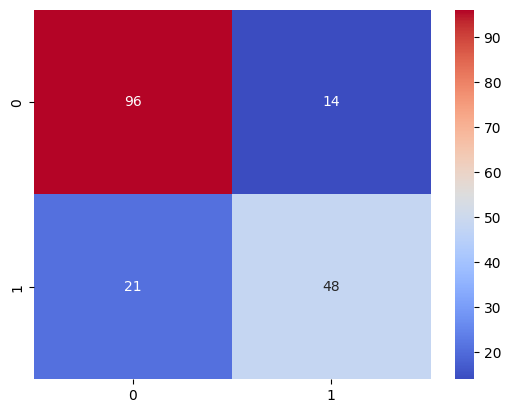

In [23]:
# Display a confusion matrix

sns.heatmap(confusion_matrix(y_valid,predictions), annot = True, cmap = 'coolwarm')

In [24]:
# Check the keys in history

print(training.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [25]:
# Get the mean of val_accuracy

val_accuracy = np.mean(training.history['val_accuracy'])

print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy*100))


val_accuracy: 78.67%


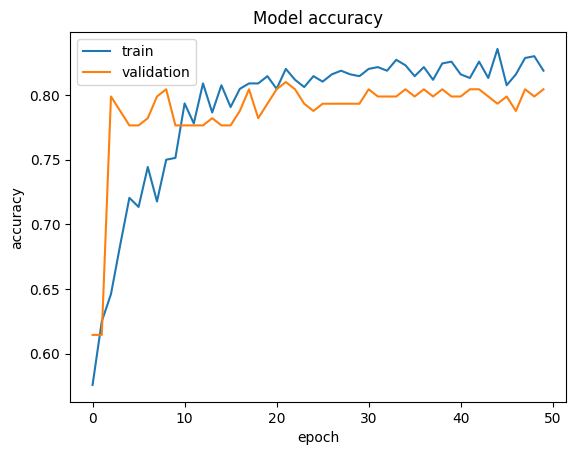

In [26]:
# Summarize history for Model accuracy

plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])

# Label and title
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

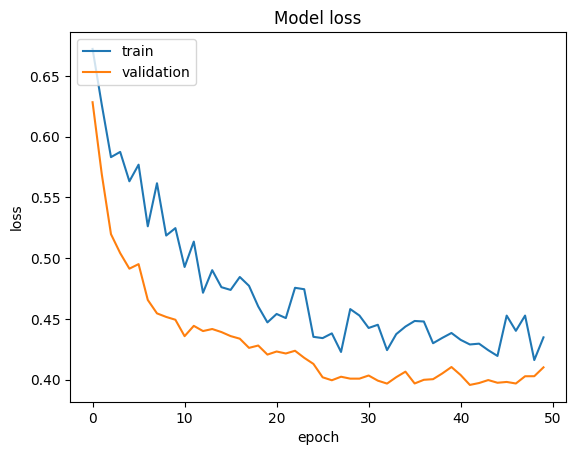

In [27]:
# Summarize history for Model loss

plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])

# Label and title
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Make a submission

In [28]:
# Make predictions on the test dataset

predictions = model.predict(df_test)

y_final = (predictions >= 0.5).astype(int).reshape(test.shape[0])


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step


In [29]:
# Create a submission file

output = pd.DataFrame({'PassengerId': test['PassengerId'],
                       'Survived': y_final})
output.to_csv('submission_keras.csv', index=False)
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


**Conclusion:**

After submission, the Neural Network with Sequential Model can get the public score = 0.78947 

So the best model for my Titanic survival prediction still be Random Forest and eXtream Gradient Boosting Model. (Part 1 of my project)
